# FloPy

## MODPATH 7 create simulation example

This notebook demonstrates how to create a simple forward and backward MODPATH 7 simulation using the `.create_mp7()` method. The notebooks also shows how to create subsets of endpoint output and plot MODPATH results on ModelMap objects.

In [1]:
import sys
import os
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

# temporary directory
temp_dir = TemporaryDirectory()
model_ws = temp_dir.name

3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]
numpy version: 1.23.1
matplotlib version: 3.5.2
flopy version: 3.3.6


In [2]:
# define executable names
mpexe = "mp7"
mfexe = "mf6"

### Flow model data

In [3]:
nper, nstp, perlen, tsmult = 1, 1, 1.0, 1.0
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.0
top = 400.0
botm = [220.0, 200.0, 0.0]
laytyp = [1, 0, 0]
kh = [50.0, 0.01, 200.0]
kv = [10.0, 0.01, 20.0]
wel_loc = (2, 10, 9)
wel_q = -150000.0
rch = 0.005
riv_h = 320.0
riv_z = 317.0
riv_c = 1.0e5

In [4]:
def get_nodes(locs):
    nodes = []
    for k, i, j in locs:
        nodes.append(k * nrow * ncol + i * ncol + j)
    return nodes

### MODPATH 7 using MODFLOW 6

#### Create and run MODFLOW 6

In [5]:
ws = os.path.join(model_ws, "mp7_ex1_cs")
nm = "ex01_mf6"

# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=nm, exe_name=mfexe, version="mf6", sim_ws=ws
)

# Create the Flopy temporal discretization object
pd = (perlen, nstp, tsmult)
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=nper, perioddata=[pd]
)

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = "{}.nam".format(nm)
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=nm, model_nam_file=model_nam_file, save_flows=True
)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
    outer_hclose=1e-6,
    inner_hclose=1e-6,
    rcloserecord=1e-6,
)

# create gwf file
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    length_units="FEET",
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=top)

# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=laytyp, k=kh, k33=kv
)


# recharge
flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rch)
# wel
wd = [(wel_loc, wel_q)]
flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
    gwf, maxbound=1, stress_period_data={0: wd}
)
# river
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z])
flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, stress_period_data={0: rd})
# Create the output control package
headfile = "{}.hds".format(nm)
head_record = [headfile]
budgetfile = "{}.cbb".format(nm)
budget_record = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_record,
    budget_filerecord=budget_record,
)

# Write the datasets
sim.write_simulation()
# Run the simulation
success, buff = sim.run_simulation()
assert success, "mf6 model did not run"

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model ex01_mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 13:50:09 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. 

    Solving:  Stress period:     1    Time step:     1
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/30 16:16:59
 Elapsed run time:  0.043 Seconds
 

WARNING REPORT:

  1. NONLINEAR BLOCK VARIABLE 'OUTER_HCLOSE' IN FILE 'ex01_mf6.ims' WAS
     DEPRECATED IN VERSION 6.1.1. SETTING OUTER_DVCLOSE TO OUTER_HCLOSE VALUE.
  2. LINEAR BLOCK VARIABLE 'INNER_HCLOSE' IN FILE 'ex01_mf6.ims' WAS
     DEPRECATED IN VERSION 6.1.1. SETTING INNER_DVCLOSE TO INNER_HCLOSE VALUE.
 Normal termination of simulation.


Get locations to extract data

In [6]:
nodew = get_nodes([wel_loc])
cellids = gwf.riv.stress_period_data.get_data()[0]["cellid"]
nodesr = get_nodes(cellids)

#### Create and run MODPATH 7

Forward tracking

In [7]:
# create modpath files
mpnamf = nm + "_mp_forward"

# create basic forward tracking modpath simulation
mp = flopy.modpath.Modpath7.create_mp7(
    modelname=mpnamf,
    trackdir="forward",
    flowmodel=gwf,
    model_ws=ws,
    rowcelldivisions=1,
    columncelldivisions=1,
    layercelldivisions=1,
    exe_name=mpexe,
)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mp7

MODPATH Version 7.2.001   
Program compiled Mar 07 2022 14:08:27 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    



Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1260 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

Backward tracking from well and river locations

In [8]:
# create modpath files
mpnamb = nm + "_mp_backward"

# create basic forward tracking modpath simulation
mp = flopy.modpath.Modpath7.create_mp7(
    modelname=mpnamb,
    trackdir="backward",
    flowmodel=gwf,
    model_ws=ws,
    rowcelldivisions=5,
    columncelldivisions=5,
    layercelldivisions=5,
    nodes=nodew + nodesr,
    exe_name=mpexe,
)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mp7

MODPATH Version 7.2.001   
Program compiled Mar 07 2022 14:08:27 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    



Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      2750 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Load and Plot MODPATH 7 output

##### Forward Tracking

Load forward tracking pathline data

In [9]:
fpth = os.path.join(ws, mpnamf + ".mppth")
p = flopy.utils.PathlineFile(fpth)
pw = p.get_destination_pathline_data(dest_cells=nodew)
pr = p.get_destination_pathline_data(dest_cells=nodesr)

Load forward tracking endpoint data

In [10]:
fpth = os.path.join(ws, mpnamf + ".mpend")
e = flopy.utils.EndpointFile(fpth)

Get forward particles that terminate in the well

In [11]:
well_epd = e.get_destination_endpoint_data(dest_cells=nodew)

Get particles that terminate in the river boundaries

In [12]:
riv_epd = e.get_destination_endpoint_data(dest_cells=nodesr)

Well and river forward tracking pathlines

In [13]:
colors = ["green", "orange", "red"]

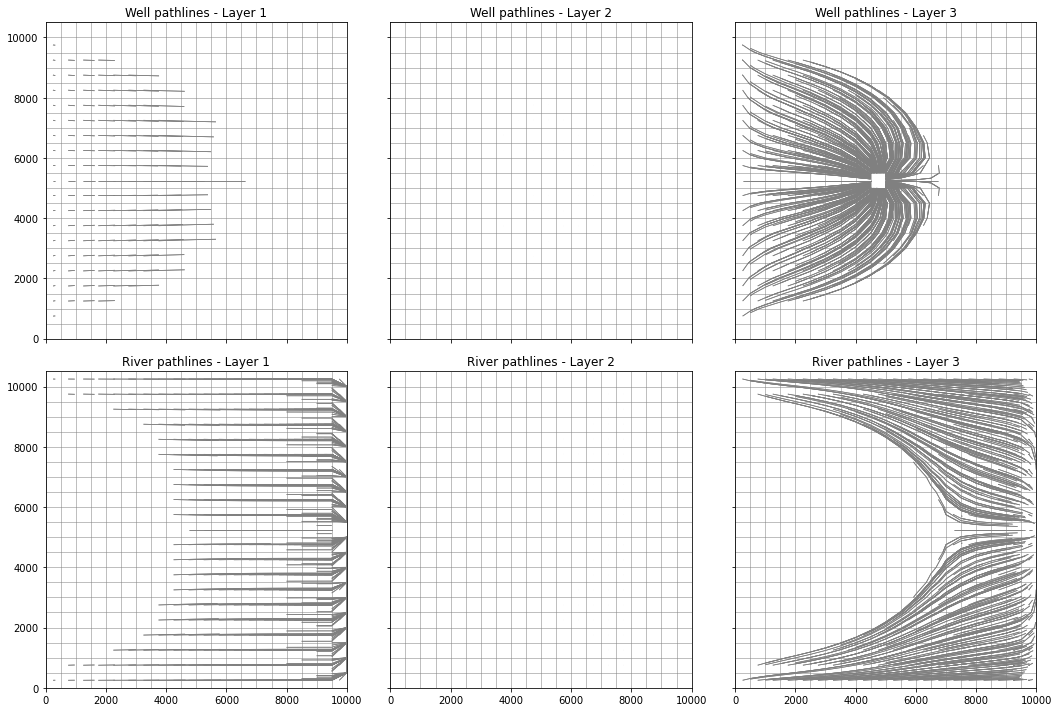

In [14]:
f, axes = plt.subplots(
    ncols=3, nrows=2, sharey=True, sharex=True, figsize=(15, 10)
)
axes = axes.flatten()

idax = 0
for k in range(nlay):
    ax = axes[idax]
    ax.set_aspect("equal")
    ax.set_title("Well pathlines - Layer {}".format(k + 1))
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)
    mm.plot_pathline(pw, layer=k, color=colors[k], lw=0.75)
    idax += 1

for k in range(nlay):
    ax = axes[idax]
    ax.set_aspect("equal")
    ax.set_title("River pathlines - Layer {}".format(k + 1))
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)
    mm.plot_pathline(pr, layer=k, color=colors[k], lw=0.75)
    idax += 1

plt.tight_layout();

Forward tracking endpoints captured by the well and river

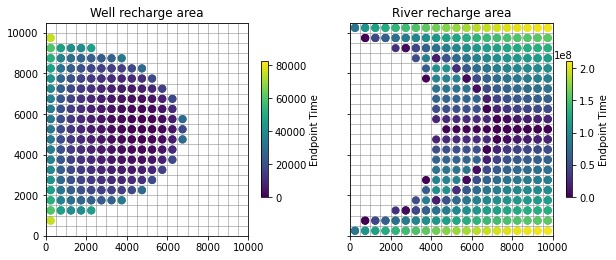

In [15]:
f, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10, 5))
axes = axes.flatten()

ax = axes[0]
ax.set_aspect("equal")
ax.set_title("Well recharge area")
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_endpoint(well_epd, direction="starting", colorbar=True, shrink=0.5)

ax = axes[1]
ax.set_aspect("equal")
ax.set_title("River recharge area")
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_endpoint(riv_epd, direction="starting", colorbar=True, shrink=0.5);

##### Backward tracking

Load backward tracking pathlines

In [16]:
fpth = os.path.join(ws, mpnamb + ".mppth")
p = flopy.utils.PathlineFile(fpth)
pwb = p.get_destination_pathline_data(dest_cells=nodew)
prb = p.get_destination_pathline_data(dest_cells=nodesr)

Load backward tracking endpoints

In [17]:
fpth = os.path.join(ws, mpnamb + ".mpend")
e = flopy.utils.EndpointFile(fpth)
ewb = e.get_destination_endpoint_data(dest_cells=nodew, source=True)
erb = e.get_destination_endpoint_data(dest_cells=nodesr, source=True)

Well backward tracking pathlines

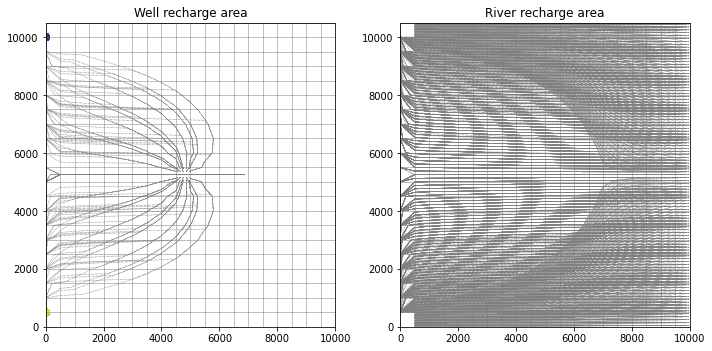

In [18]:
f, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

ax = axes[0]
ax.set_aspect("equal")
ax.set_title("Well recharge area")
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(
    pwb,
    layer="all",
    color="blue",
    lw=0.5,
    linestyle=":",
    label="captured by wells",
)
mm.plot_endpoint(ewb, direction="ending")  # , colorbar=True, shrink=0.5);

ax = axes[1]
ax.set_aspect("equal")
ax.set_title("River recharge area")
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(
    prb,
    layer="all",
    color="green",
    lw=0.5,
    linestyle=":",
    label="captured by rivers",
)

plt.tight_layout();